This code calibrates the stochastic HyMoLAP model following the algorithm developed in: Sianou Ezéckiel Houénafa, Erick K. Erick K. Ronoh, Olatunji Johnson et al. Lévy-induced Stochastic Differential Equation Models in Rainfall-Runoff Systems for Assessing Extreme Hydrological Event Risks, 15 July 2024, PREPRINT (Version 1) available at Research Square [https://doi.org/10.21203/rs.3.rs-4618006/v1].

1- We tested many cases of noise parameters, such as $\alpha$ = np.arange(1, 2.06, 0.1) and $\beta$ = np.arange(-1, 1, 0.2). We retained the case that provided the best NSE performance on average which is $\alpha=1.3$ and $\beta=-0.8$.

2- The ranges of $\mu$, $\beta$, and $\theta$ parameters defined were derived based on the deterministic HyMoLAP model calibration. In fact, the parameters are assumed to be similar for both cases. For calibrating the deterministic model, the same approach was considered (without the Lévy process). We started with large parameter ranges, which we manually reduced over time to achieve more accurate and robust results.

3- The condition:  if Qsim[k - 1] < 0, Qsim[k - 1] = 0 was employed because some simulations were influenced by Lévy noise, and we needed to ensure positive values to reflect physically realistic conditions.







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import random
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
random.seed(10)
daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Bonou/calage_biao.xlsx')
daily.head()

discharge = daily.iloc[:1461, 0].to_numpy()
plui = daily.iloc[:1461, 1].to_numpy()
etp = daily.iloc[:1461, 2].to_numpy()
random.seed(10)


#Compute the Effective precipitation
plui_eff = plui - etp
plui_eff[plui_eff < 0] = 0


# X(t)
def state_basin(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]
    return X



In [ ]:
# Performance metrics

def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse


Heuristic method

In [ ]:
from scipy.stats import levy_stable

In [ ]:
x = discharge

# Levy parameters
alpha = 1.3
beta = -0.8

max_traj = 200
SIG = np.zeros(max_traj)
MU = np.zeros(max_traj)
LAMBDA = np.zeros(max_traj)
QQ = np.zeros((len(x), max_traj))


for traj in range(max_traj):
    # Stable noise simulation
    Lev = levy_stable.rvs(alpha, beta, loc=0, scale=1, size=len(x))

    # Model initialization
    nashe = 0
    Qsim = np.zeros(len(x))
    Qsim[0] = x[0]
    Q1 = np.zeros(len(x))

    for pp in range(5000):
        mu = (0.95 - 0.75) * np.random.rand() + 0.75   # which is a in the paper
        lambda_ = (3.4 - 2) * np.random.rand() + 2   # which is b in the paper
        sigma = np.random.rand() * 0.1             # which is theta in the paper
        X = state_basin(mu, lambda_, plui_eff)     # which y(t) in the paper

        for k in range(1, len(x)):
            if Qsim[k - 1] < 0:
                Qsim[k - 1] = 0
            Qsim[k] = (Qsim[k - 1] - (mu / lambda_) * Qsim[k - 1] ** (2 * mu - 1) + (1 / lambda_) * X[k-1] * plui_eff[k - 1] +
                       sigma * Qsim[k - 1] * (Lev[k] - Lev[k - 1]))

        # Nash-Sutcliffe efficiency calculation
        nas = nash_sutcliffe_efficiency(x, Qsim)
        if nashe < nas:
            nashe = nas
            mu1 = mu
            lambda1 = lambda_
            sigma1 = sigma
            Q1 = Qsim.copy()

    SIG[traj] = sigma1
    MU[traj] = mu1
    LAMBDA[traj] = lambda1
    QQ[:, traj] = Q1

mean_SIGMA = np.mean(SIG)
mean_MU = np.mean(MU)
mean_LAMBDA = np.mean(LAMBDA)

mean_trajectory = np.mean(QQ, axis=1)
nse = nash_sutcliffe_efficiency(x, mean_trajectory)


In [ ]:
print(nse)

0.884713462398691


In [ ]:
print(mean_MU)
print(mean_LAMBDA)
print(mean_SIGMA)

0.8135652054539424
2.941609906557787
0.003527634586281278


In [ ]:
# Build confidence interval (CI)
infq_trajectory = np.percentile(QQ, 2.5, axis=1)
supq_trajectory = np.percentile(QQ, 97.5, axis=1)

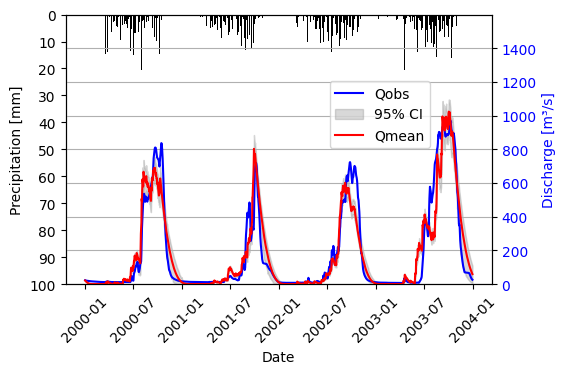

In [ ]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2000-01-02')
time2 = np.datetime64('2003-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(5.5, 3.5))

# Plot a histogram for precipitation (plui) on ax1
ax1.bar(time, plui[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date')

# Set y-axis parameters for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 10))

# Invert the y-axis and place the ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge[1:], 'b', label='Qobs')

# Plot a confidence region
ax2.fill_between(time, infq_trajectory[1:], supq_trajectory[1:], color='gray', alpha=0.3, label='95% CI')

# Plot the mean trajectory
ax2.plot(time, mean_trajectory[1:], 'r', label='Qmean')

# Configure y-axis for discharge
ax2.set_ylabel('Discharge [m³/s]', color='blue')  # Label for discharge axis
ax2.tick_params(axis='y', labelcolor='blue')  # Set tick color for the discharge axis
ax2.set_ylim(0, 1600)  # Set y-axis range for discharge
ax2.set_yticks(np.arange(0, 1600, 200))  # Set y-axis ticks at intervals of 400 m³/s

# Add a legend inside the plot
fig.legend(loc='upper right', bbox_to_anchor=(0.8, 0.71))

# Display the grid
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
discharge1 = daily.iloc[1461:, 0].to_numpy()
plui1 = daily.iloc[1461:, 1].to_numpy()
etp1 = daily.iloc[1461:, 2].to_numpy()

#Compute the Effective precipitation
plui_eff1 = plui1 - etp1
plui_eff1[plui_eff1 < 0] = 0


# Simulation with the SDE
size = len(discharge1)
n_traj = 300000
QQ = np.zeros((size,n_traj))

X = state_basin(mean_MU, mean_LAMBDA, plui_eff1)

for i in range(n_traj):

   #Simulate Lévy process
   Lev=[]
   Lev = levy_stable.rvs(alpha, beta, loc=0, scale=1, size=size)

   # Model
   S = np.zeros(size)
   S[0] = discharge1[0]
   Phi1 = np.zeros(len(discharge1))
   Phi1[0] = plui_eff1[0]
   for k in range(1, size):
        if S[k - 1]<0:
          S[k - 1] = 0
        S[k] = (S[k - 1] - (mean_MU/mean_LAMBDA) * S[k-1]**(2*mean_MU-1) + (1/mean_LAMBDA) * X[k-1] * plui_eff1[k-1] +
                 mean_SIGMA * S[k - 1] * (Lev[k]-Lev[k - 1]))

   QQ[:, i] = S.copy()

mean_trajectory1 = np.mean(QQ, axis=1)


In [ ]:
print('nse=',nash_sutcliffe_efficiency(discharge1[1:], mean_trajectory1[1:]))

nse= 0.8384828955679337


In [ ]:
infq_trajectory1 = np.percentile(QQ, 2.5, axis=1)
supq_trajectory1 = np.percentile(QQ, 97.5, axis=1)

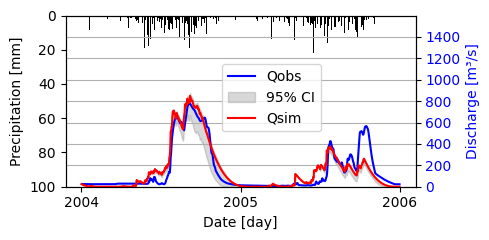

In [ ]:
import matplotlib.dates as mdates

# Generate the date range
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with specified dimensions
fig, ax1 = plt.subplots(figsize=(5., 2.5))

# Plot precipitation (plui1) as bars on ax1
ax1.bar(time, plui1[1:], color='black')

# Format the x-axis to show only the start of each year
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Align x-axis labels horizontally (no rotation)
plt.xticks(rotation=0)

# Label for the x-axis
ax1.set_xlabel('Date [day]')

# Configure y-axis for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")  # Position the y-axis label on the left

# Create a second y-axis for discharge (Qobs)
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b', label='Qobs')

# Plot a confidence region
ax2.fill_between(time, infq_trajectory1[1:], supq_trajectory1[1:], color='gray', alpha=0.3, label='95% CI')

# Plot the mean trajectories (Qsim)
ax2.plot(time, mean_trajectory1[1:], 'red', label='Qsim')

# Configure y-axis for discharge
ax2.set_ylabel('Discharge [m³/s]', color='blue')  # Label for discharge axis
ax2.tick_params(axis='y', labelcolor='blue')  # Set tick color for the discharge axis
ax2.set_ylim(0, 1600)  # Set y-axis range for discharge
ax2.set_yticks(np.arange(0, 1600, 200))  # Set y-axis ticks at intervals of 400 m³/s

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.44, 0.75))

# Use tight_layout to prevent label overlap
plt.tight_layout()

# Save the plot as a .jpeg file
plt.savefig("sto_hyb_wxgb.jpeg", format='jpeg', dpi=500)

plt.grid(True)

# Optional: Download the saved file
# files.download("sto_hyb_wxgb.jpeg")

# Display the plot
plt.show()
